In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow import keras

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import visualkeras
import cv2
import os

np.random.seed(42)

# Data Load & Data Pre-processing

In [2]:
X_DATA_PATH = "./data/cropped/"
Y_DATA_PATH = "./data/resized/"

x_data_path_list = os.listdir(X_DATA_PATH)[:32 * 50]
y_data_path_list = os.listdir(Y_DATA_PATH)[:32 * 50]

X, y = list(), list()
for x_data_path in tqdm(x_data_path_list, desc=f'X data loading...'):   X.append(cv2.imread(X_DATA_PATH + x_data_path))
for y_data_path in tqdm(y_data_path_list, desc=f'Y data loading...'):   y.append(cv2.imread(Y_DATA_PATH + y_data_path))

Y data loading...: 100%|██████████| 1000/1000 [00:00<00:00, 2026.01it/s]


In [3]:
len(x_data_path_list)

1000

In [4]:
X = np.array(X)
y = np.array(y)

# plt.title("Original Image Boxplot")
# plt.boxplot(X.reshape(-1, 3))
# plt.boxplot(y.reshape(-1, 3))
# plt.show()

# Pre-processing
X = X.astype('float32') / 255.
y = y.astype('float32') / 255.

# for i in range(len(x_data_path_list)):
#     X[i, :, :, :] = X[i, :, :, :].astype('float32') / 255.
#     y[i, :, :, :] = y[i, :, :, :].astype('float32') / 255.
#     print(f'{i + 1} / 25000')
                

# plt.title("Normalized Image Boxplot")
# plt.boxplot(X.reshape(-1, 3))
# plt.boxplot(y.reshape(-1, 3))
# plt.show()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"""X_train shape: {X_train.shape}
y_train shape: {y_train.shape}
X_test shape: {X_test.shape}
y_test shape: {y_test.shape}""")

X_train shape: (700, 256, 256, 3)
y_train shape: (700, 256, 256, 3)
X_test shape: (300, 256, 256, 3)
y_test shape: (300, 256, 256, 3)


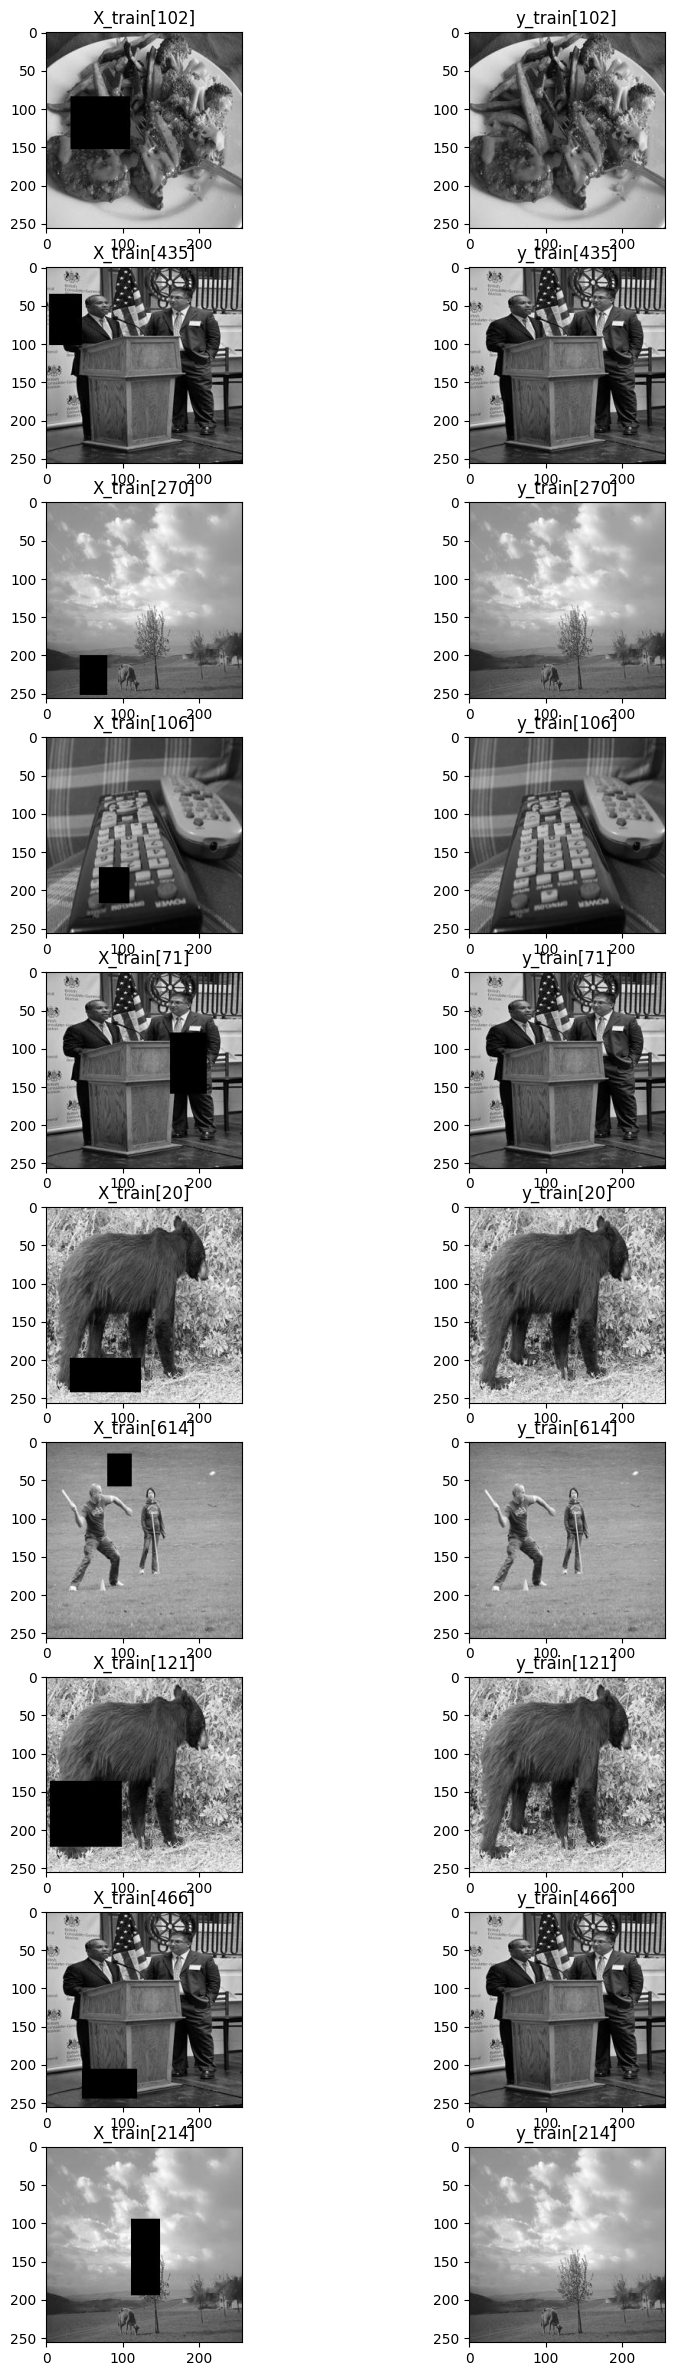

In [6]:
randlist = np.random.randint(0, X_train.shape[0], 10)

ax, fig = plt.subplots(10, 2, figsize=(10, 30))
for i, j in zip(range(10), randlist):
    fig[i][0].title.set_text(f"X_train[{j}]")
    fig[i][1].title.set_text(f"y_train[{j}]")
    fig[i][0].imshow(X_train[j])
    fig[i][1].imshow(y_train[j])
plt.show()

# Modeling

In [7]:
outDir = './checkpoint_unet/' # 이 경로에 best 모델이 저장된다.
model_names = outDir + 'weights-{epoch}-{val_loss:.8f}.h5'
def get_callbacks(patience = 50):
    model_checkpoint = ModelCheckpoint(model_names, monitor='val_loss', save_best_only=True, period = 1)
    callbacks = [model_checkpoint]
    return callbacks

callback = get_callbacks()

In [12]:
# ResNet BottleNeck Block
def BottleNeck(input_feature, in_channels, out_channels):
    x1 = Conv2D(in_channels, (1, 1), padding='same', activation='relu')(input_feature)
    x1 = layers.BatchNormalization()(x1)
    skip_connection = x1

    x1 = Conv2D(in_channels, (3, 3), padding='same', activation='relu')(x1)
    x1 = layers.BatchNormalization()(x1)

    x1 = Conv2D(out_channels, (1, 1), padding='same', activation='relu')(x1)
    x1 = layers.BatchNormalization()(x1)

    x1 = layers.add([x1, skip_connection])
    x1 = layers.Activation('relu')(x1)

    return x1

# Import U-Net
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    x1 = BottleNeck(inputs, 64, 64)
    x1 = BottleNeck(x1, 64, 64)

    x2 = MaxPooling2D((2, 2))(x1)
    x2 = BottleNeck(x2, 128, 128)
    x2 = BottleNeck(x2, 128, 128)

    x3 = MaxPooling2D((2, 2))(x2)
    x3 = BottleNeck(x3, 256, 256)
    x3 = BottleNeck(x3, 256, 256)

    x4 = MaxPooling2D((2, 2))(x3)
    x4 = BottleNeck(x4, 512, 512)
    x4 = BottleNeck(x4, 512, 512)

    up1 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x4), x3], axis=-1)
    up1 = BottleNeck(up1, 256, 256)
    up1 = BottleNeck(up1, 256, 256)

    up2 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(up1), x2], axis=-1)
    up2 = BottleNeck(up2, 128, 128)
    up2 = BottleNeck(up2, 128, 128)

    up3 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(up2), x1], axis=-1)
    up3 = BottleNeck(up3, 64, 64)
    up3 = BottleNeck(up3, 64, 64)

    classify = Conv2D(3, (1, 1), activation='tanh')(up3)
    model = Model(inputs=inputs, outputs=classify)

    return model

In [14]:
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

In [15]:
model = unet(input_size=(256, 256, 3))
optimizer_f = keras.optimizers.Adam(learning_rate=0.0001)
loss_f = keras.losses.MeanSquaredError()

model.compile(optimizer=optimizer_f, loss=loss_f, metrics=['accuracy', psnr])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_129 (Conv2D)         (None, 256, 256, 64)         256       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_126 (B  (None, 256, 256, 64)         256       ['conv2d_129[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv2d_130 (Conv2D)         (None, 256, 256, 64)         36928     ['batch_normalization_12

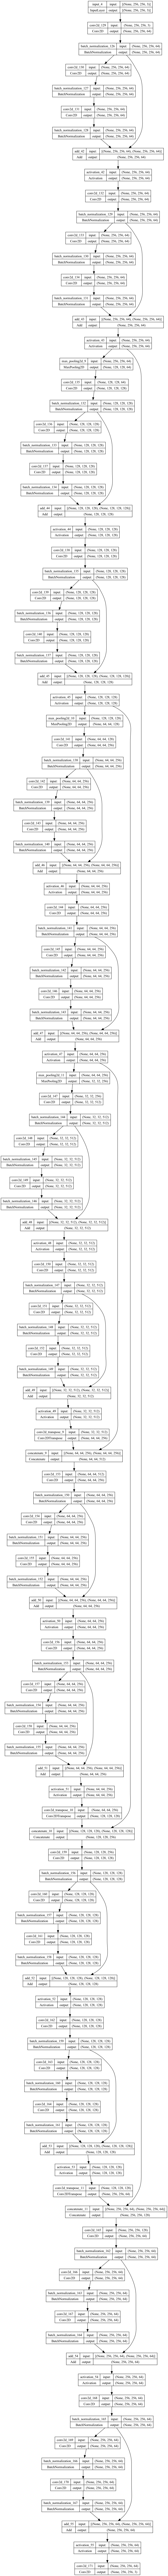

In [16]:
plot_model(model, to_file='model.png', show_shapes=True)

# Training & Validation

In [17]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [18]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=4,
    verbose=1,
    callbacks=[callback]
)

Epoch 1/100
 16/175 [=>............................] - ETA: 7:17 - loss: 0.7104 - accuracy: 0.2288 - psnr: 1.8070

# Model Train Result

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

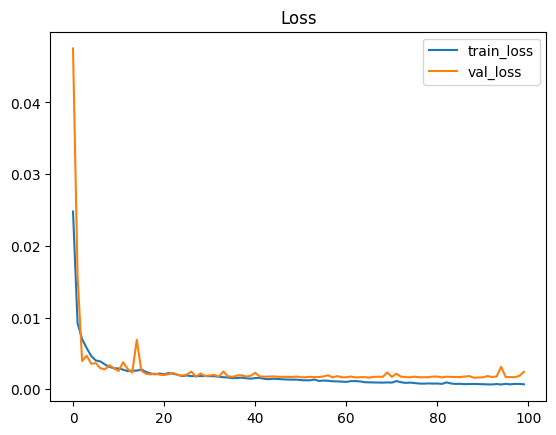

In [ ]:
plt.title("Loss")
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend()
plt.show()

In [ ]:
plt.title("Accuracy")
plt.plot(train_loss, label="train_accuracy")
plt.plot(val_loss, label="val_accuracy")
plt.legend()
plt.show()

# Evaluation

15/15 [==============================] - 7s 489ms/step


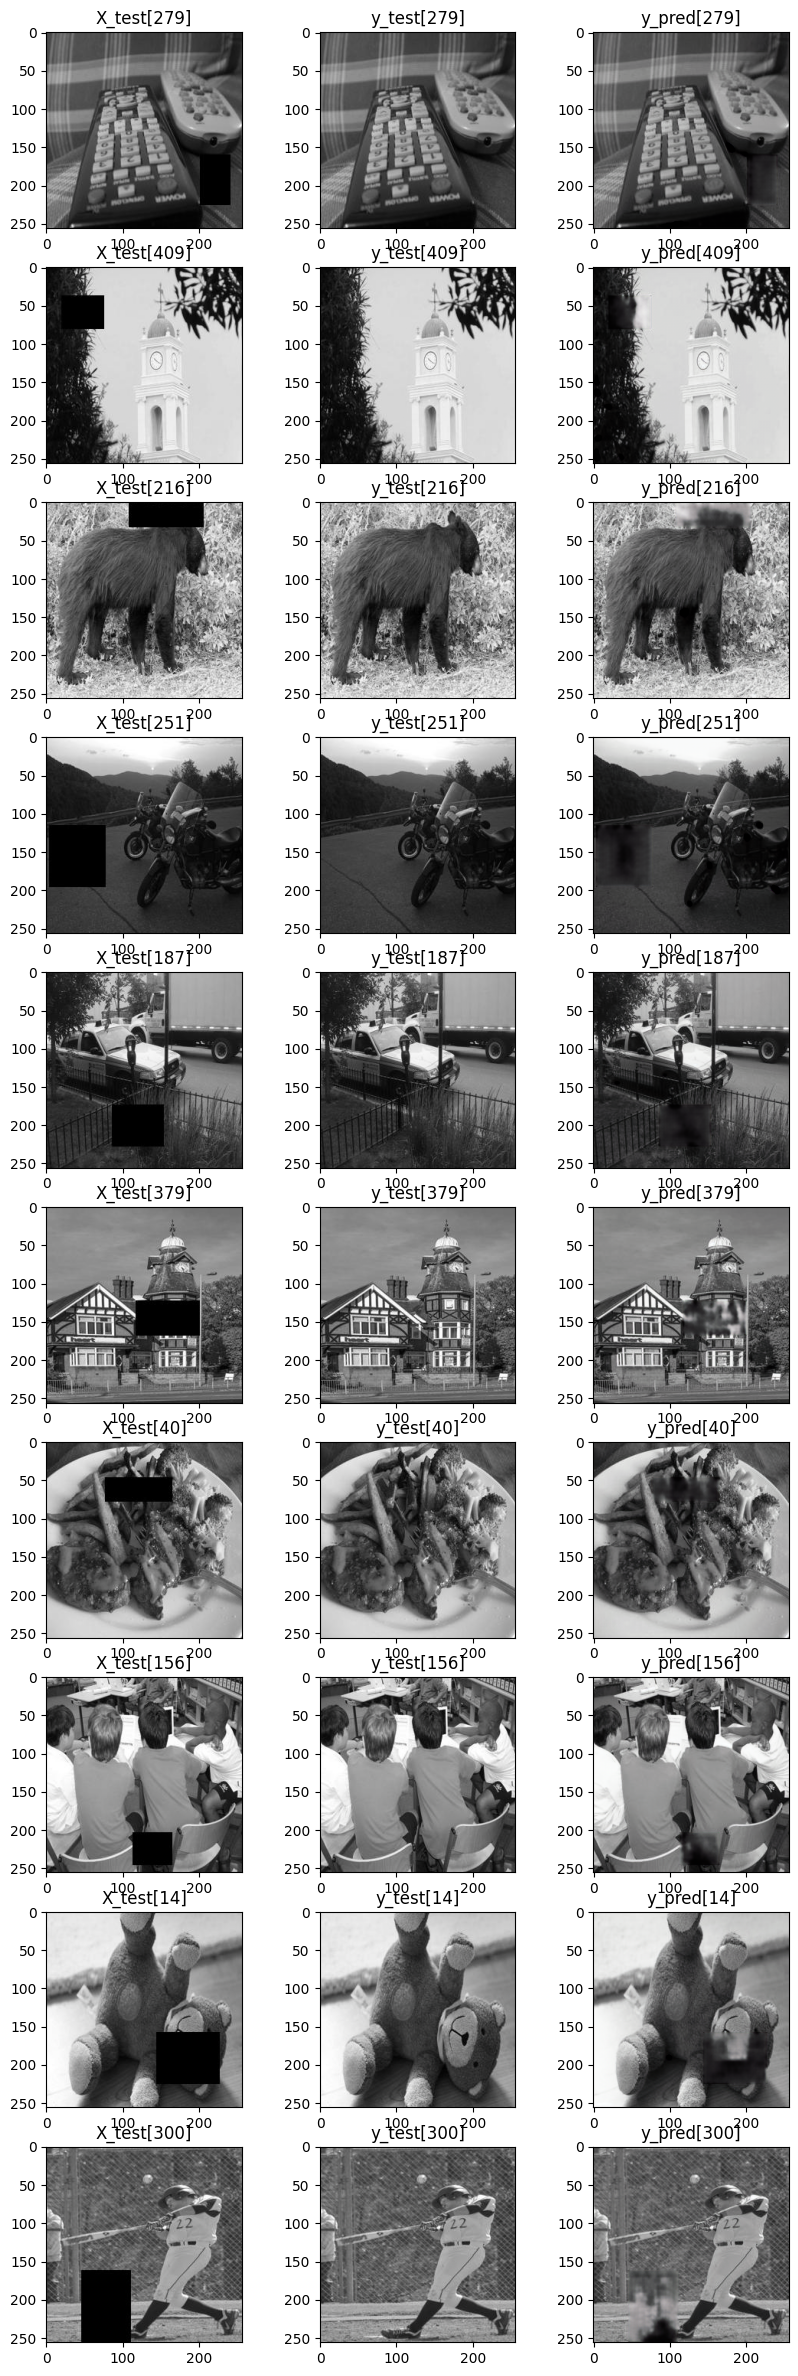

In [28]:
y_pred = model.predict(X_test)

randlist = np.random.randint(0, X_test.shape[0], 10)

ax, fig = plt.subplots(10, 3, figsize=(10, 30))
for i, j in zip(range(10), randlist):
    fig[i][0].title.set_text(f"X_test[{j}]")
    fig[i][1].title.set_text(f"y_test[{j}]")
    fig[i][2].title.set_text(f"y_pred[{j}]")
    fig[i][0].imshow(X_test[j])
    fig[i][1].imshow(y_test[j])
    fig[i][2].imshow(y_pred[j])

In [32]:
test_img = cv2.imread('../test_preprocessed.png') / 255.
test_list = np.array([test_img])
test_pred = model.predict(test_list)

1/1 [==============================] - 0s 22ms/step


In [33]:
test_pred.shape

(1, 256, 256, 3)

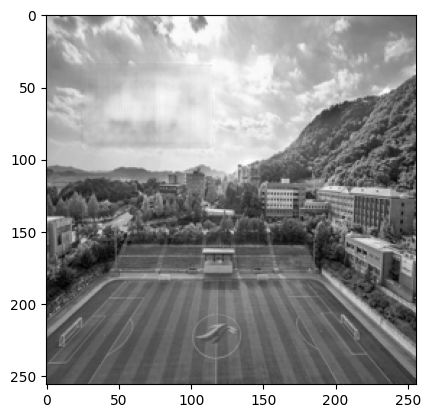

In [34]:
plt.imshow(test_pred[0][:, :, 0], cmap = "gray")
cv2.imwrite('../test_output.png', test_pred[0][:, :, 0])
plt.show()

1/1 [==============================] - 0s 22ms/step


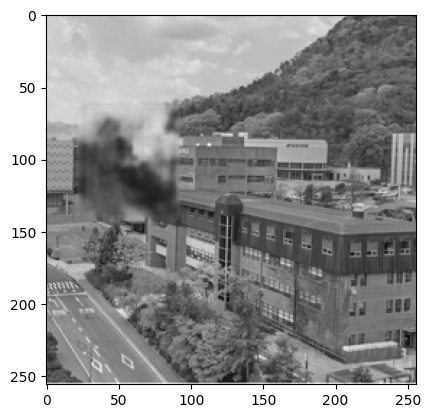

In [35]:
test_img = cv2.imread('../test2_preprocessed.png') / 255.
test_list = np.array([test_img])
test_pred = model.predict(test_list)
plt.imshow(test_pred[0][:, :, 0], cmap = "gray")
cv2.imwrite('../test2_output.png', test_pred[0][:, :, 0])
plt.show()

1/1 [==============================] - 0s 23ms/step


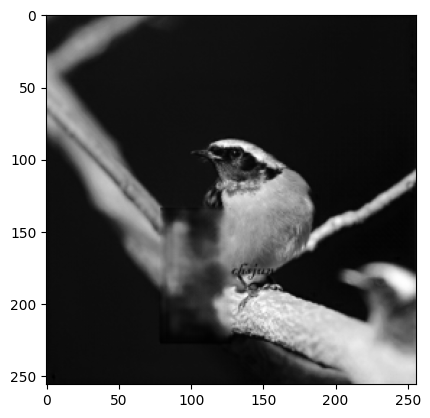

In [41]:
test_img = cv2.imread('../test4_preprocessed.png') / 255.
test_list = np.array([test_img])
test_pred = model.predict(test_list)
plt.imshow(test_pred[0][:, :, 0], cmap = "gray")
cv2.imwrite('../test4_output.png', test_pred[0][:, :, 0])
plt.show()

1/1 [==============================] - 0s 25ms/step


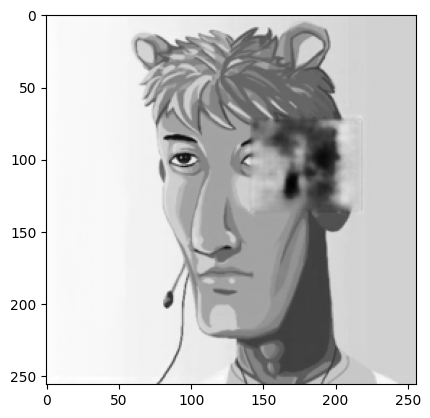

In [42]:
test_img = cv2.imread('../test5_preprocessed.png') / 255.
test_list = np.array([test_img])
test_pred = model.predict(test_list)
plt.imshow(test_pred[0][:, :, 0], cmap = "gray")
cv2.imwrite('../test5_output.png', test_pred[0][:, :, 0])
plt.show()

1/1 [==============================] - 0s 26ms/step


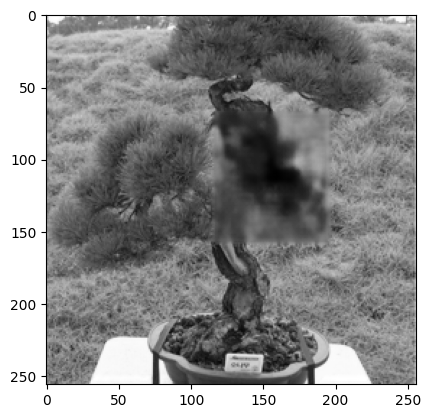

In [46]:
test_img = cv2.imread('../test7_preprocessed.png') / 255.
test_list = np.array([test_img])
test_pred = model.predict(test_list)
plt.imshow(test_pred[0][:, :, 0], cmap = "gray")
cv2.imwrite('../test7_output.png', test_pred[0][:, :, 0])
plt.show()